In [16]:
import pandas as pd
import json
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Load JSON
with open('combined_papers.json') as f:
    data = json.load(f)

print(f"✓ Data loaded successfully!")
print(f"Total curves: {len(data['curves'])}")
print(f"\nFirst curve structure:")
print(f"  - ID: {data['curves'][1]['curve_id']}")
print(f"  - Composition: {data['curves'][1]['alloy_composition']}")
print(f"  - Data points: {len(data['curves'][1]['curve_raw_data']['data'])}")

✓ Data loaded successfully!
Total curves: 392

First curve structure:
  - ID: fig14a-293K
  - Composition: {'Co': 20.0, 'Cr': 20.0, 'Fe': 20.0, 'Mn': 20.0, 'Ni': 20.0}
  - Data points: 35


In [24]:
def extract_features_from_curve(curve_data, debug=False):
    """
    Extract comprehensive features from a stress-strain curve.
    Set debug=True to see intermediate calculations.
    """
    # === STEP 1: Check if data is valid ===
    if not curve_data or len(curve_data) < 6:
        if debug:
            print(" Skipping: Not enough data points")
        return None
    
    if debug:
        print(f"\n{'='*60}")
        print(f"Processing curve with {len(curve_data)} data points")
        print(f"{'='*60}")
    
    # === STEP 2: Convert to arrays ===
    strains_unsorted = np.array([p['x'] for p in curve_data])
    stresses_unsorted = np.array([p['y'] for p in curve_data])
    
    if debug:
        print(f"\n Raw data ranges:")
        print(f"  Strain: {strains_unsorted.min():.4f} to {strains_unsorted.max():.4f}")
        print(f"  Stress: {stresses_unsorted.min():.2f} to {stresses_unsorted.max():.2f} MPa")
    
    # === STEP 3: Sort by strain ===
    sort_idx = np.argsort(strains_unsorted)
    strains = strains_unsorted[sort_idx]
    stresses = stresses_unsorted[sort_idx]
    
    if debug:
        print(f"\n✓ Data sorted by strain")
    
    # Initialize features dictionary
    features = {}
    
    # === STEP 4: Basic Mechanical Properties ===
    features['ultimate_tensile_strength'] = np.max(stresses)
    features['max_strain'] = np.max(strains)
    features['uts_strain'] = strains[np.argmax(stresses)]
    
    if debug:
        print(f"\n🔧 Basic Properties:")
        print(f"  UTS: {features['ultimate_tensile_strength']:.2f} MPa")
        print(f"  Max Strain: {features['max_strain']:.4f}")
        print(f"  UTS occurs at strain: {features['uts_strain']:.4f}")
    
    # === STEP 5: Yield Strength (0.2% offset approximation) ===
    if strains[0] <= 0.002 <= strains[-1]:
        f_interp = interp1d(strains, stresses, kind='linear', fill_value='extrapolate')
        features['yield_strength_002'] = float(f_interp(0.002))
        if debug:
            print(f"  Yield Strength (0.2%): {features['yield_strength_002']:.2f} MPa")
    else:
        features['yield_strength_002'] = stresses[0]
        if debug:
            print(f"  Yield Strength (approx): {features['yield_strength_002']:.2f} MPa (using first point)")
    
    # === STEP 6: Stress at specific strain points ===
    strain_points = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
    if debug:
        print(f"\n📍 Stress at specific strains:")
    
    for sp in strain_points:
        if strains[0] <= sp <= strains[-1]:
            f_interp = interp1d(strains, stresses, kind='linear', fill_value='extrapolate')
            features[f'stress_at_{sp}'] = float(f_interp(sp))
            if debug:
                print(f"  At ε={sp}: σ={features[f'stress_at_{sp}']:.2f} MPa")
        else:
            features[f'stress_at_{sp}'] = np.nan
            if debug:
                print(f"  At ε={sp}: N/A (outside range)")
    
    # # === STEP 7: Work Hardening Analysis ===
    # if len(strains) > 5:
    #     # Smooth the curve
    #     window = min(5, len(stresses) if len(stresses) % 2 == 1 else len(stresses) - 1)
    #     if window >= 3:
    #         stresses_smooth = savgol_filter(stresses, window, 2)
    #     else:
    #         stresses_smooth = stresses
        
    #     # Calculate hardening rate (dσ/dε)
    #     d_stress = np.diff(stresses_smooth)
    #     d_strain = np.diff(strains)
    #     hardening_rate = d_stress / (d_strain + 1e-10)
        
    #     features['avg_hardening_rate'] = np.mean(hardening_rate)
    #     features['max_hardening_rate'] = np.max(hardening_rate)
    #     features['min_hardening_rate'] = np.min(hardening_rate)
    #     features['std_hardening_rate'] = np.std(hardening_rate)
        
        # # Hardening at different stages
        # n_points = len(hardening_rate)
        # features['hardening_rate_early'] = np.mean(hardening_rate[:n_points//3])
        # features['hardening_rate_mid'] = np.mean(hardening_rate[n_points//3:2*n_points//3])
        # features['hardening_rate_late'] = np.mean(hardening_rate[2*n_points//3:])
        
        # if debug:
        #     print(f"\n⚙️ Work Hardening (dσ/dε):")
        #     print(f"  Average: {features['avg_hardening_rate']:.2f}")
        #     print(f"  Max: {features['max_hardening_rate']:.2f}")
        #     print(f"  Min: {features['min_hardening_rate']:.2f}")
        #     print(f"  Early stage: {features['hardening_rate_early']:.2f}")
        #     print(f"  Mid stage: {features['hardening_rate_mid']:.2f}")
        #     print(f"  Late stage: {features['hardening_rate_late']:.2f}")
    
    # === STEP 8: Energy Metrics ===
    features['toughness'] = np.trapz(stresses, strains)
    elastic_idx = int(len(strains) * 0.2)
    features['resilience'] = np.trapz(stresses[:elastic_idx], strains[:elastic_idx])
    
    if debug:
        print(f"\n⚡ Energy:")
        print(f"  Toughness (total): {features['toughness']:.2f}")
        print(f"  Resilience (elastic): {features['resilience']:.2f}")
    
    # === STEP 9: Statistical Features ===
    features['stress_mean'] = np.mean(stresses)
    features['stress_std'] = np.std(stresses)
    features['stress_median'] = np.median(stresses)
    features['stress_25_percentile'] = np.percentile(stresses, 25)
    features['stress_75_percentile'] = np.percentile(stresses, 75)
    features['stress_range'] = np.max(stresses) - np.min(stresses)
    
    if debug:
        print(f"\n📊 Statistics:")
        print(f"  Mean: {features['stress_mean']:.2f} MPa")
        print(f"  Std: {features['stress_std']:.2f} MPa")
        print(f"  Median: {features['stress_median']:.2f} MPa")
    
    # # === STEP 10: Curve Shape Features ===
    # features['num_data_points'] = len(strains)
    # features['strain_range'] = np.max(strains) - np.min(strains)
    
    # n = len(strains)
    # early_slope = (stresses[n//4] - stresses[0]) / (strains[n//4] - strains[0] + 1e-10)
    # mid_slope = (stresses[n//2] - stresses[n//4]) / (strains[n//2] - strains[n//4] + 1e-10)
    # late_slope = (stresses[-1] - stresses[n//2]) / (strains[-1] - strains[n//2] + 1e-10)
    
    # features['early_slope'] = early_slope
    # features['mid_slope'] = mid_slope
    # features['late_slope'] = late_slope
    
    # if debug:
    #     print(f"\n📈 Slopes:")
    #     print(f"  Early (0-25%): {features['early_slope']:.2f}")
    #     print(f"  Mid (25-50%): {features['mid_slope']:.2f}")
    #     print(f"  Late (50-100%): {features['late_slope']:.2f}")
        print(f"\n✅ Feature extraction complete! Total features: {len(features)}")
    
    return features

print("✓ Function defined successfully!")

✓ Function defined successfully!


In [27]:
# Test on the first curve with debug mode ON
print("🔍 Testing feature extraction on FIRST curve:\n")
test_features = extract_features_from_curve(
    data['curves'][0]['curve_raw_data']['data'], 
    debug=True
)

# print(f"\n\n📋 Extracted features:")
# for key, value in test_features.items():
#     print(f"  {key}: {value}")

🔍 Testing feature extraction on FIRST curve:


Processing curve with 50 data points

 Raw data ranges:
  Strain: 0.0110 to 0.8900
  Stress: 592.33 to 1115.82 MPa

✓ Data sorted by strain

🔧 Basic Properties:
  UTS: 1115.82 MPa
  Max Strain: 0.8900
  UTS occurs at strain: 0.8280
  Yield Strength (approx): 592.33 MPa (using first point)

📍 Stress at specific strains:
  At ε=0.01: N/A (outside range)
  At ε=0.02: σ=615.89 MPa
  At ε=0.05: σ=676.93 MPa
  At ε=0.1: σ=747.66 MPa
  At ε=0.2: σ=857.54 MPa
  At ε=0.3: σ=945.82 MPa
  At ε=0.5: σ=1056.02 MPa

⚡ Energy:
  Toughness (total): 860.18
  Resilience (elastic): 74.91

📊 Statistics:
  Mean: 950.20 MPa
  Std: 161.91 MPa
  Median: 1012.02 MPa

✅ Feature extraction complete! Total features: 19


/var/folders/xy/0xhnpbcd2fsby1z0rgb21v_40000gn/T/ipykernel_18176/4206670164.py:110: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['toughness'] = np.trapz(stresses, strains)
/var/folders/xy/0xhnpbcd2fsby1z0rgb21v_40000gn/T/ipykernel_18176/4206670164.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['resilience'] = np.trapz(stresses[:elastic_idx], strains[:elastic_idx])


In [39]:
def normalize_composition(composition_dict):
    """
    Normalize composition dictionary keys to standard element symbols,
    convert wt.% to at.% if needed, and SKIP non-element keys.
    """
    import re
    
    # Valid chemical elements
    VALID_ELEMENTS = {
        'Al', 'Co', 'Cr', 'Cu', 'Fe', 'Mg', 'Mn', 'Mo', 'Nb', 'Nd', 
        'Ni', 'Si', 'Ti', 'V', 'W', 'Y', 'Zn', 'Zr', 'C', 'N', 'O', 
        'S', 'P', 'B', 'H', 'Li', 'Be', 'Ca', 'Sc', 'Ga', 'Ge', 'As',
        'Se', 'Ag', 'Sn', 'Sb', 'Ta', 'Hf', 'Re', 'Pd', 'Pt', 'Au'
    }
    
    # Atomic weights (g/mol)
    ATOMIC_WEIGHTS = {
        'Al': 26.982, 'Co': 58.933, 'Cr': 51.996, 'Cu': 63.546,
        'Fe': 55.845, 'Mg': 24.305, 'Mn': 54.938, 'Mo': 95.95,
        'Nb': 92.906, 'Nd': 144.242, 'Ni': 58.693, 'Si': 28.085,
        'Ti': 47.867, 'V': 50.942, 'W': 183.84, 'Y': 88.906,
        'Zn': 65.38, 'Zr': 91.224, 'C': 12.011, 'N': 14.007,
        'O': 15.999, 'S': 32.06, 'P': 30.974, 'B': 10.81,
        'Ta': 180.948, 'Hf': 178.49
    }
    
    # Check if conversion is needed
    needs_conversion = any('wt' in str(key).lower() for key in composition_dict.keys())
    
    # Step 1: Clean keys and filter out non-elements
    cleaned = {}
    skipped_keys = []
    
    for key, value in composition_dict.items():
        # Skip if value is not a number
        try:
            float(value)
        except (ValueError, TypeError):
            skipped_keys.append(key)
            continue
        
        # Clean the key
        clean_key = re.sub(r'\s*\(wt\.?%?\)|\s*\(at\.?%?\)|\s*_wt%?|\s*_at%?|\s*wt%?|\s*at%?', 
                          '', key, flags=re.IGNORECASE)
        clean_key = clean_key.strip()
        
        # Standardize capitalization
        if len(clean_key) == 1:
            clean_key = clean_key.upper()
        elif len(clean_key) >= 2:
            clean_key = clean_key[0].upper() + clean_key[1:].lower()
        
        # ✅ ONLY ADD IF IT'S A VALID ELEMENT
        if clean_key in VALID_ELEMENTS:
            cleaned[clean_key] = float(value)
        else:
            skipped_keys.append(key)
    
    if skipped_keys:
        pass  # Silently skip non-element keys
        # Uncomment below to see what was skipped
        # print(f"    ⏩ Skipped non-element keys: {skipped_keys}")
    
    # Step 2: Convert wt.% to at.% if needed
    if needs_conversion and cleaned:
        mole_fractions = {}
        for element, wt_percent in cleaned.items():
            if element in ATOMIC_WEIGHTS:
                mole_fractions[element] = wt_percent / ATOMIC_WEIGHTS[element]
            else:
                mole_fractions[element] = wt_percent
        
        total_moles = sum(mole_fractions.values())
        
        if total_moles > 0:
            at_percent = {elem: (moles / total_moles) * 100 
                         for elem, moles in mole_fractions.items()}
            return at_percent
    
    return cleaned

In [40]:
# Extract for ALL curves with normalization, conversion, AND filtering
feature_list = []
composition_list = []
skipped = 0
converted_count = 0

print("Processing all curves (filtering non-element columns)...")
for i, curve in enumerate(data['curves']):
    features = extract_features_from_curve(curve['curve_raw_data']['data'], debug=False)
    
    if features is not None:
        # Check if this needs conversion
        original_comp = curve['alloy_composition']
        needs_conversion = any('wt' in str(key).lower() for key in original_comp.keys())
        
        if needs_conversion:
            converted_count += 1
        
        # Normalize, convert, AND filter non-elements
        normalized_comp = normalize_composition(original_comp)
        
        # Only add if we have valid composition data
        if normalized_comp:
            feature_list.append(features)
            composition_list.append(normalized_comp)
        else:
            skipped += 1
    else:
        skipped += 1
    
    # Progress indicator
    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(data['curves'])} curves...")

print(f"\n✓ Feature extraction complete!")
print(f"  Successfully processed: {len(feature_list)} curves")
print(f"  Converted wt%→at%: {converted_count} curves")
print(f"  Skipped (insufficient data): {skipped} curves")


   

Processing all curves (filtering non-element columns)...
  Processed 50/392 curves...
  Processed 100/392 curves...
  Processed 150/392 curves...
  Processed 200/392 curves...
  Processed 250/392 curves...
  Processed 300/392 curves...
  Processed 350/392 curves...

✓ Feature extraction complete!
  Successfully processed: 382 curves
  Converted wt%→at%: 16 curves
  Skipped (insufficient data): 10 curves


/var/folders/xy/0xhnpbcd2fsby1z0rgb21v_40000gn/T/ipykernel_18176/4206670164.py:110: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['toughness'] = np.trapz(stresses, strains)
/var/folders/xy/0xhnpbcd2fsby1z0rgb21v_40000gn/T/ipykernel_18176/4206670164.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features['resilience'] = np.trapz(stresses[:elastic_idx], strains[:elastic_idx])
/opt/homebrew/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/homebrew/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [41]:
# Create DataFrames
X = pd.DataFrame(feature_list)
y = pd.DataFrame(composition_list)

print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"\nFeature matrix (X) shape: {X.shape}")
print(f"Target matrix (y) shape: {y.shape}")

print(f"\n Feature names ({len(X.columns)} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

print(f"\nTarget (composition) names ({len(y.columns)} total):")
for i, col in enumerate(y.columns, 1):
    print(f"  {i}. {col}")

# print(f"\n🧪 First 5 rows of features:")
# print(X.head())

# print(f"\n🎯 First 5 rows of compositions:")
# print(y.head())




FINAL RESULTS

Feature matrix (X) shape: (382, 19)
Target matrix (y) shape: (382, 22)

 Feature names (19 total):
  1. ultimate_tensile_strength
  2. max_strain
  3. uts_strain
  4. yield_strength_002
  5. stress_at_0.01
  6. stress_at_0.02
  7. stress_at_0.05
  8. stress_at_0.1
  9. stress_at_0.2
  10. stress_at_0.3
  11. stress_at_0.5
  12. toughness
  13. resilience
  14. stress_mean
  15. stress_std
  16. stress_median
  17. stress_25_percentile
  18. stress_75_percentile
  19. stress_range

Target (composition) names (22 total):
  1. Co
  2. Cr
  3. Fe
  4. Mn
  5. Ni
  6. Al
  7. Cu
  8. V
  9. Si
  10. Mg
  11. Y
  12. Nd
  13. Zr
  14. Ti
  15. C
  16. Mo
  17. Ta
  18. Hf
  19. B
  20. Nb
  21. W
  22. N


In [42]:
# Check for NaN values
missing = X.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️ Missing values found:")
    print(missing[missing > 0])
    
    # Fill with median
    X_filled = X.fillna(X.median())
    print(f"\n✓ Missing values filled with median")
    print(f"  Before: {X.isnull().sum().sum()} NaN values")
    print(f"  After: {X_filled.isnull().sum().sum()} NaN values")
    X = X_filled
else:
    print("\n✅ No missing values!")


⚠️ Missing values found:
yield_strength_002      8
stress_at_0.01        135
stress_at_0.02         73
stress_at_0.05         40
stress_at_0.1          57
stress_at_0.2         132
stress_at_0.3         209
stress_at_0.5         305
dtype: int64

✓ Missing values filled with median
  Before: 959 NaN values
  After: 0 NaN values


In [43]:
from sklearn.feature_selection import VarianceThreshold

print("\n🔍 Checking for low-variance features:")
print(f"Features before: {X.shape[1]}")

# Remove features with variance < 0.01
selector = VarianceThreshold(threshold=0.01)
X_high_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

X = pd.DataFrame(X_high_var, columns=selected_features, index=X.index)
print(f"Features after: {X.shape[1]}")
print(f"✓ Removed {len(X.columns) - X.shape[1]} low-variance features")


🔍 Checking for low-variance features:
Features before: 19
Features after: 19
✓ Removed 0 low-variance features



📊 Checking feature distributions:


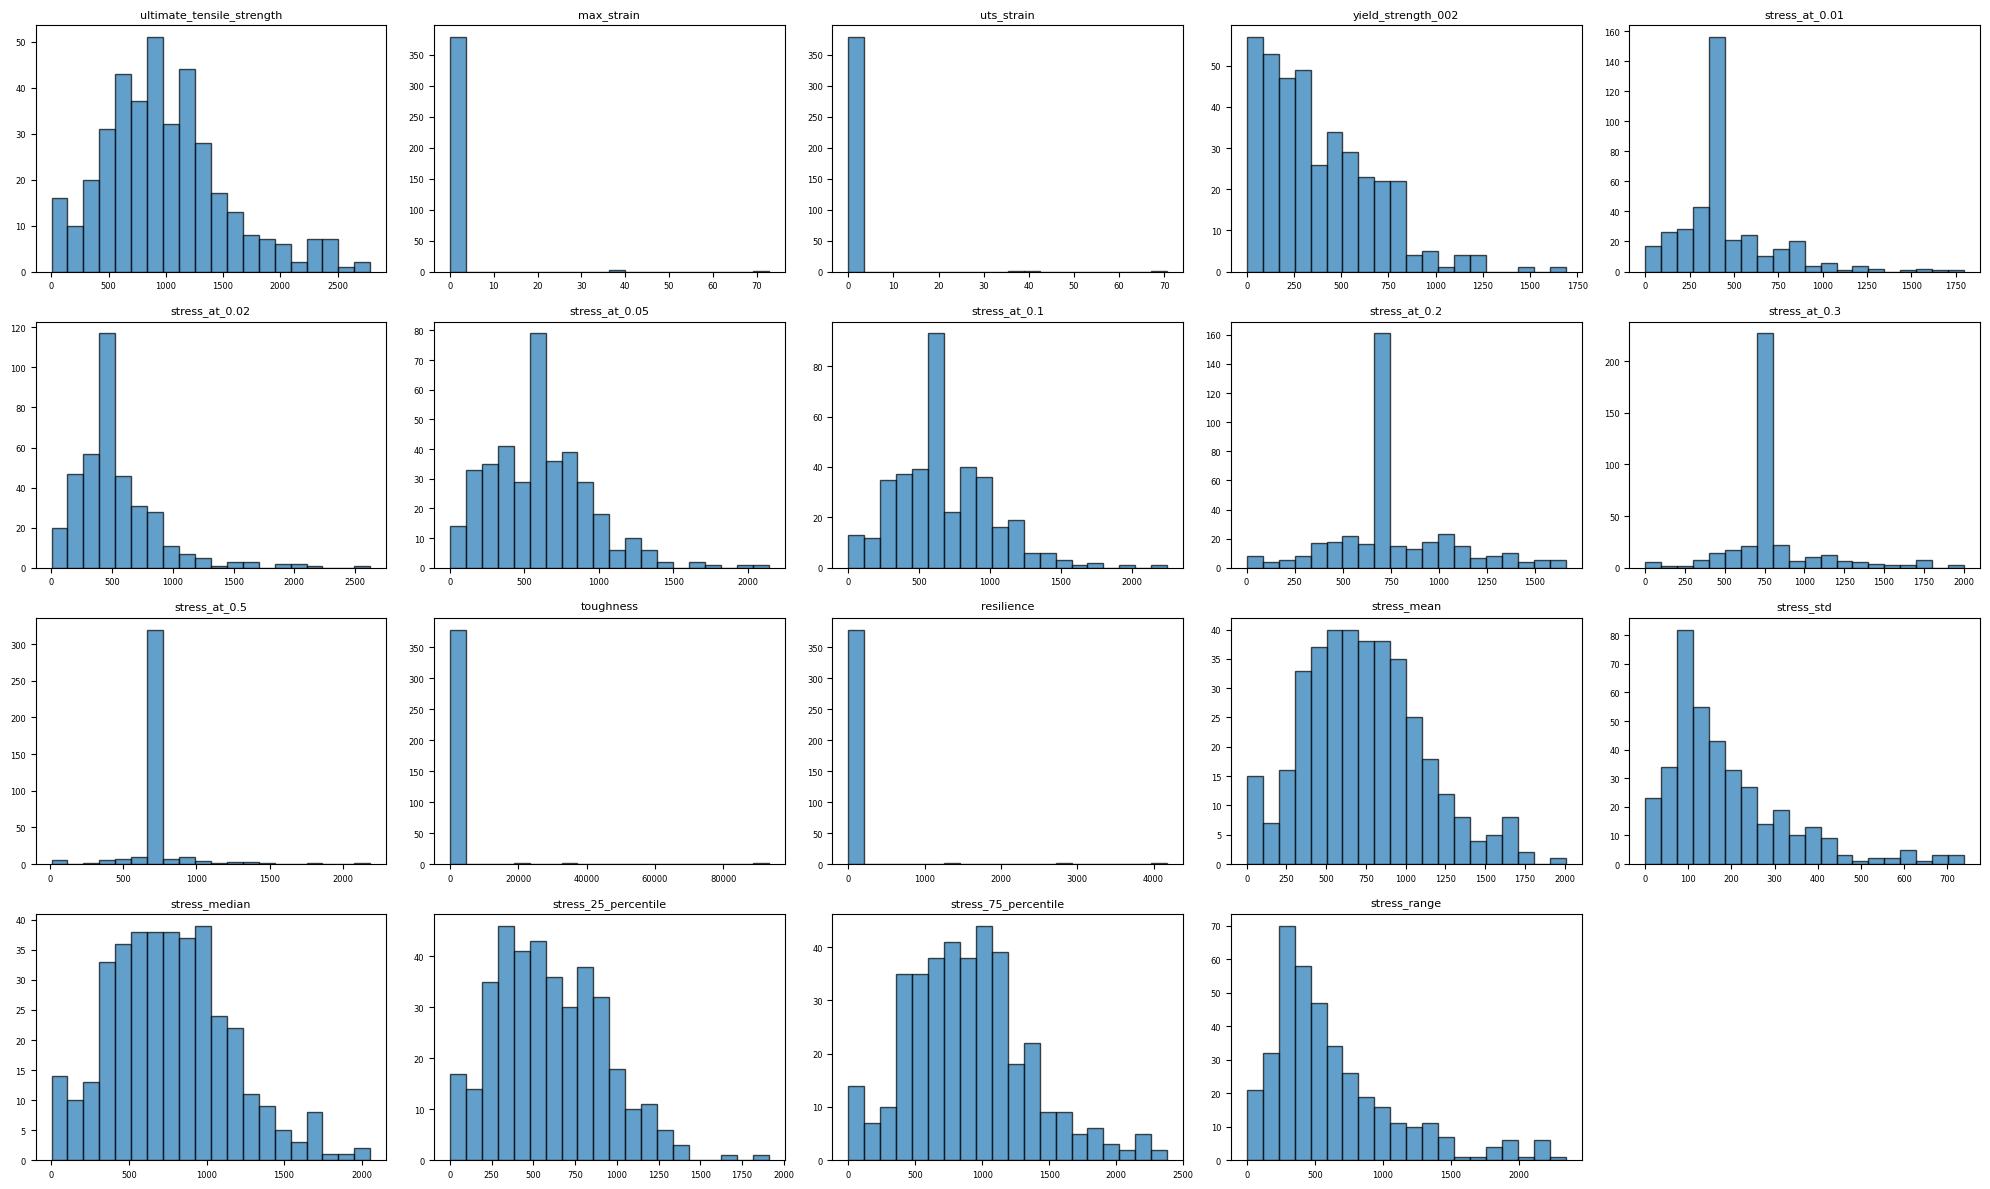

✓ Check the plots for any extreme outliers or skewed distributions


In [47]:
import matplotlib.pyplot as plt
import numpy as np

print("\n📊 Checking feature distributions:")

num_features = len(X.columns)
cols = 5  # 5 plots per row
rows = int(np.ceil(num_features / cols))  # enough rows to fit all

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].hist(X[col].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(labelsize=6)

# Turn off unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print("✓ Check the plots for any extreme outliers or skewed distributions")



📊 Target (composition) distribution:
               Co          Cr          Fe          Mn          Ni          Al  \
count  331.000000  333.000000  325.000000  159.000000  237.000000  151.000000   
mean    19.072713   18.344198   29.076978   22.712830   26.378570   11.375848   
std      5.984443    5.939276   12.971072    6.974144    8.699822    5.860409   
min      1.000000    6.220000    2.500000    0.500000    6.000000    0.000000   
25%     16.390000   15.000000   18.200000   20.000000   20.000000    6.250000   
50%     20.000000   16.400000   23.970000   20.000000   24.390000   10.000000   
75%     22.500000   21.280000   40.000000   28.000000   33.330000   16.390000   
max     34.000000   39.390000   72.670000   45.000000   73.125000   25.000000   

              Cu          V         Si         Mg  ...         Zr         Ti  \
count  72.000000  12.000000  85.000000  16.000000  ...  30.000000  37.000000   
mean    9.591667  19.983333   4.758824  98.103072  ...   5.127597  16.48

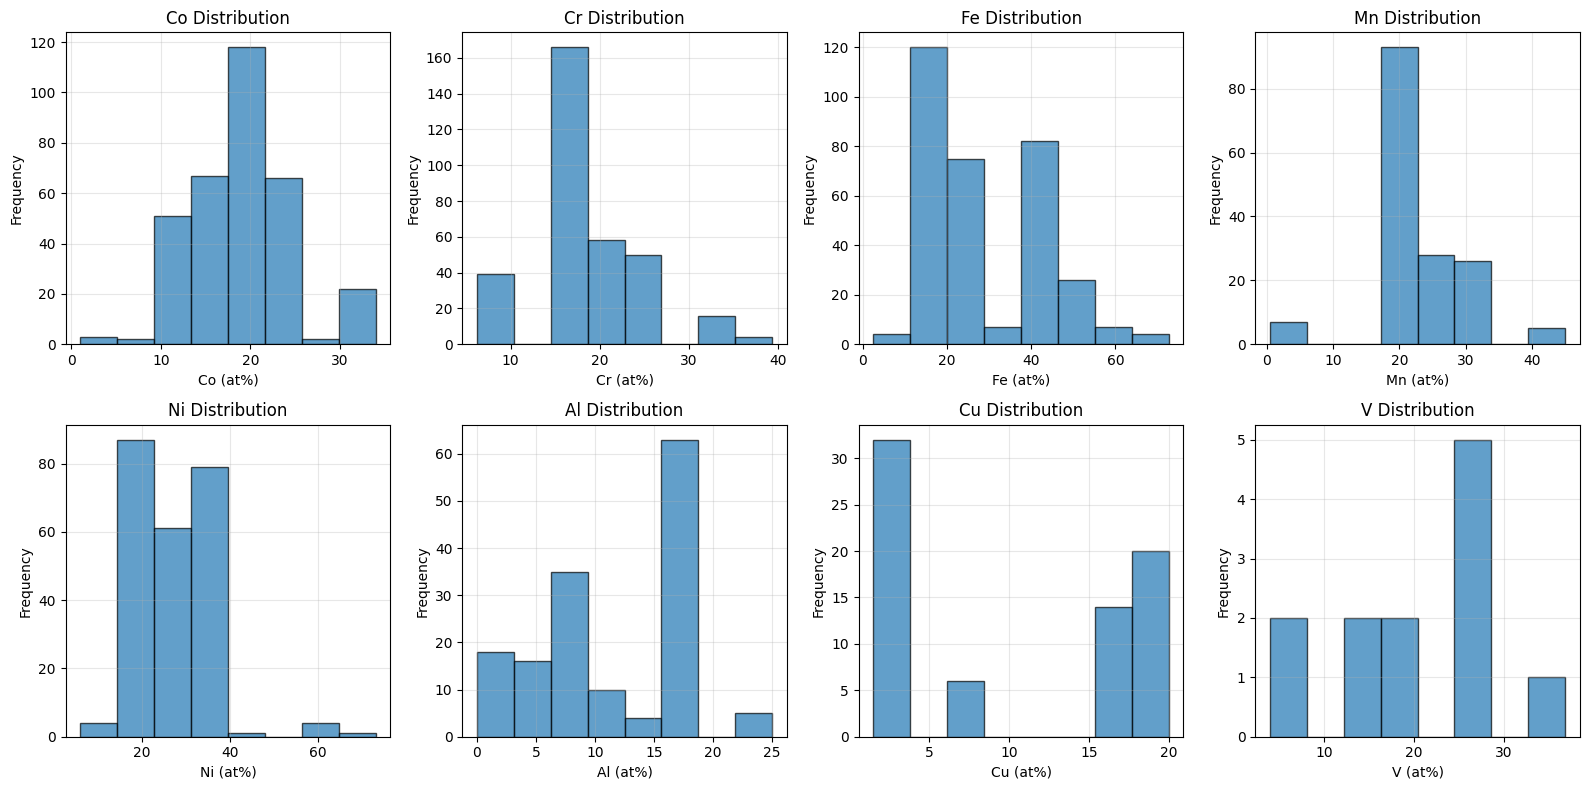


✓ Check if any elements are rarely present (may cause issues)


In [53]:
# Check if compositions are balanced
print("\n📊 Target (composition) distribution:")
print(y.describe())

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(y.columns[:8]):  # First 8 elements
    axes[i].hist(y[col], bins=8, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(f'{col} (at%)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{col} Distribution')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Check if any elements are rarely present (may cause issues)")

In [57]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nData Split Summary:")
print(f"  Training samples (X): {X_train.shape[0]}")
print(f"  Test samples (X): {X_test.shape[0]}")
print(f"  Training target samples (y): {y_train.shape[0]}")
print(f"  Test target samples (y): {y_test.shape[0]}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Number of target elements: {y_train.shape[1]}")



Data Split Summary:
  Training samples (X): 305
  Test samples (X): 77
  Training target samples (y): 305
  Test target samples (y): 77
  Number of features: 19
  Number of target elements: 22
